In [1]:
import numpy as np
import pandas as pd
import sklearn
import tqdm
from mat2vec.processing import MaterialsTextProcessor
from pymatgen.analysis import magnetism
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    SelectPercentile,
    VarianceThreshold,
    chi2,
    f_classif,
    f_regression,
    mutual_info_classif,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

C:\Users\giovanni\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
data = pd.read_excel('estm.xlsx')
data = data[['Formula', 'temperature(K)', 'ZT']]

data['Components'] = 0
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(data))):
    data['Components'].iloc[i] = normalizer.normalized_formula(data['Formula'].iloc[i])
    
grouped_df = data.groupby('Components')
grouped_ZT = grouped_df['ZT'].apply(list).reset_index()
grouped_temperature = grouped_df['temperature(K)'].apply(list).reset_index()
grouped_temperature['ZT'] = grouped_ZT['ZT']


100%|████████████████████████████████████████████████████████████████████████████| 5205/5205 [00:01<00:00, 4557.74it/s]


In [4]:
def recompose_df(df):

    new_data = {'Components': [], 'temperature(K)': [], 'ZT': []}
    for index, row in df.iterrows():
        formula = row['Components']
        temperatures = row['temperature(K)']
        zt_values = row['ZT']

        for temperature, zt_value in zip(temperatures, zt_values):
            new_data['Components'].append(formula)
            new_data['temperature(K)'].append(temperature)
            new_data['ZT'].append(zt_value)

    new_df = pd.DataFrame(new_data)
    new_df = new_df.groupby(['Components', 'temperature(K)'])['ZT'].apply(list).reset_index()
    
    new_df['rsd'] = 0
    for i in range(len(new_df)):
        new_df['rsd'].iloc[i] = 100*np.std(new_df['ZT'].iloc[i])/np.mean(new_df['ZT'].iloc[i])
        new_df['ZT'].iloc[i] = np.mean(new_df['ZT'].iloc[i])
        
    new_df = new_df[new_df['rsd']<20]
    new_df = new_df.iloc[:, :-1]
    
    return(new_df)

In [5]:
grouped_temperature['temperature(K)'] = grouped_temperature['temperature(K)'].apply(lambda x: x[0])
grouped_temperature['ZT'] = grouped_temperature['ZT'].apply(lambda x: x[0])

## Featurization

In [6]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [8]:
Data_train, Data_test = train_test_split(grouped_temperature, test_size=0.2, random_state=0)
train_df = featurizing(Data_train)
test_df = featurizing(Data_test)
train_df['temperature(K)'] = list(Data_train['temperature(K)'])
test_df['temperature(K)'] = list(Data_test['temperature(K)'])
train_df['ZT'] = list(Data_train['ZT'])
test_df['ZT'] = list(Data_test['ZT'])

MultipleFeaturizer:   0%|          | 0/696 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/174 [00:00<?, ?it/s]

## Model training/validation/testing

In [8]:
etr = ExtraTreesRegressor(random_state = 0)

pipe = Pipeline([
    ('decorrelation', MyDecorrelator(0.9)), 
    ('threshold', VarianceThreshold(threshold = 0)), 
    ('feature_selector', SelectPercentile(f_regression)), 
    ('etr', etr)
], verbose = 1)

param_grid = {
    "etr__n_estimators": [100, 250, 500],                     #Tune the number of estimators
    "etr__max_features": [1, 0.75, 0.5],                      #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [50, 75, 100]             #Tune the percentage of features to retain in terms of f_regression score
}

search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = 5)

In [17]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   3.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   3.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  46.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.4s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.4min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.6s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x0000019B3F59ED38>)),
                                       ('etr',
                                        ExtraTreesRegressor(bootstrap=False,
                                                            ccp_alpha=0.0,
                                                            criterion='mse',
                                                            max_d...
                                                            min_weight

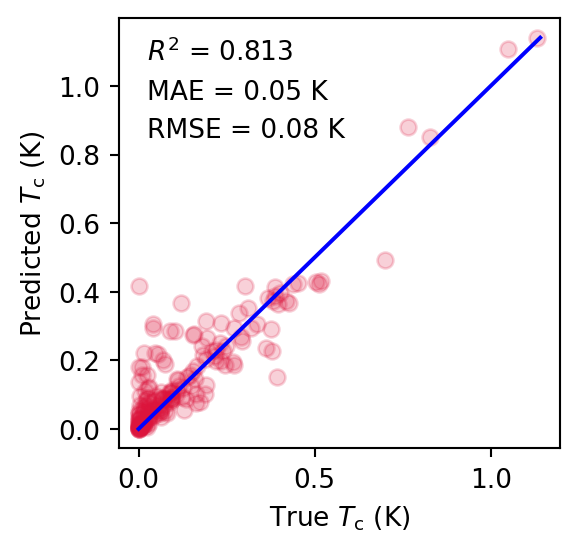

In [10]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values


test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

In [11]:
search.best_params_

{'etr__max_features': 0.5,
 'etr__n_estimators': 100,
 'feature_selector__percentile': 75}

## Manual refitting

In [12]:
X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

In [13]:
correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)

In [14]:
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [15]:
X_train = X_train.loc[:, SelectPercentile(f_regression, percentile = 75).fit(X_train, y_train).get_support()]
X_test = X_test[X_train.columns]

In [16]:
etr = ExtraTreesRegressor(random_state=0, n_estimators = 100, max_features = 0.5)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.5, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

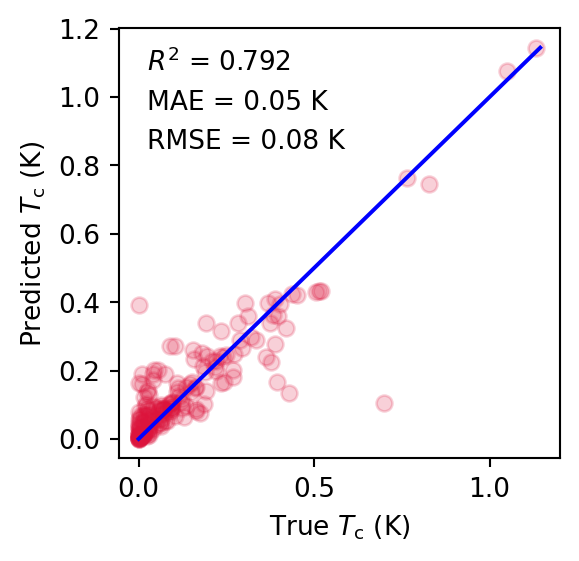

In [17]:
y_predictions = etr.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_predictions)
mae = mean_absolute_error(y_test, y_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3), dpi = 190)
plt.scatter(test_labels, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

In [20]:
import shap
explainer = shap.TreeExplainer(etr)
shap_values = explainer.shap_values(X_test)

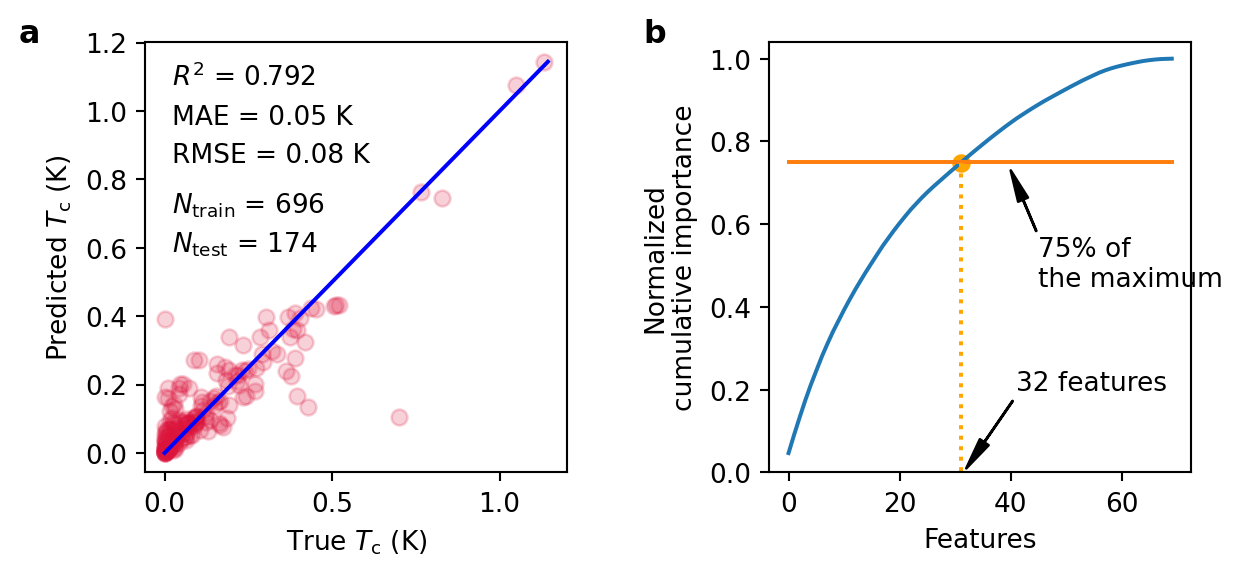

In [19]:
N = np.shape(X_test)[1]
k = 0.75
import matplotlib.pyplot as plt
cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])/(np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi = 190)                                                                                       
ax1.scatter(test_labels, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
ax1.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
ax1.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)

ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), 
             xy=(0.02 * delta, 0.62 * delta), 
             xytext=(0.02 * delta, 0.62 * delta),
            )
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), 
             xy=(0.02 * delta, 0.52 * delta), 
             xytext=(0.02 * delta, 0.52 * delta),
            )

ax1.set_xlabel("True $T_\mathrm{c}$ (K)")
ax1.set_ylabel("Predicted $T_\mathrm{c}$ (K)")

ax1.annotate(
    r"$\mathbf{a}$",
    xy=(-4, 120),
    xytext=(-50, 140),
    fontsize = 14
)

ax1.annotate(
    r"$\mathbf{b}$",
    xy=(120, 120),
    xytext=(155, 140),
    fontsize = 14
)

ax1.annotate('a', xy=(-.3, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k*max(normalized_cumulative)*np.ones(N)))
#plt.yticks(np.array([0, 0.5, 1]))

ax2.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax2.annotate('75% of\nthe maximum', xy=(40, 0.73), xytext=(45, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color = 'orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color = 'orange', ls = ':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')
ax2.annotate('b', xy=(-.3, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')


plt.subplots_adjust(wspace=0.48)
plt.show()

In [22]:
Output_shap = pd.DataFrame(shap_values, index = X_test.index, columns = X_test.columns)
Output_shap_mean = pd.DataFrame(abs(Output_shap).describe().loc['mean']/sum(abs(Output_shap).describe().loc['mean'])).sort_values('mean', ascending = False)

In [23]:
Output_shap_mean.to_excel('SHAP_ranking_thermoelectrics.xlsx')

In [20]:
sum(Output_shap_mean['mean'].iloc[:32])

0.748500027529244

In [22]:
from joblib import dump, load
dump(search, 'ETR_estm.joblib') 

['ETR_estm.joblib']

## Validation #1

In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [21]:
reduced_Data = pd.concat([train_df, test_df])[list(Output_shap_mean.index)[:32]]

In [22]:
K = 20

silhouette_scores_agglo = np.zeros(K)

for i in tqdm.tqdm(range(K)):
    agglo = AgglomerativeClustering(n_clusters=2)
    labels_agglo = agglo.fit_predict(reduced_Data.iloc[:, :i+1])
    silhouette_scores_agglo[i] = silhouette_score(reduced_Data, labels_agglo)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.20it/s]


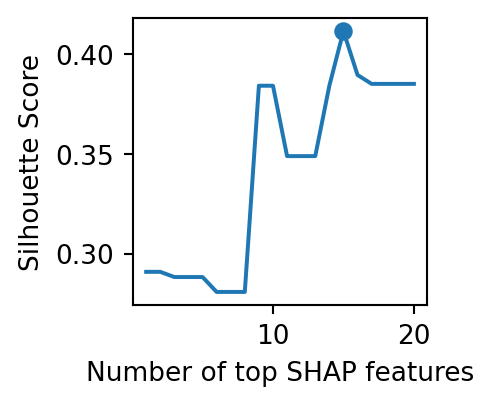

In [25]:
plt.figure(figsize=(2, 2), dpi=190)
plt.plot(range(1, K + 1), silhouette_scores_agglo)

# Scatter plot for the maximum Silhouette score
max_index = np.argmax(silhouette_scores_agglo) + 1
max_value = np.max(silhouette_scores_agglo)
plt.scatter(max_index, max_value)

# Labels
plt.xlabel('Number of top SHAP features')
plt.ylabel('Silhouette Score')
plt.show()


In [29]:
agglo = AgglomerativeClustering(n_clusters=2)
labels_agglo = agglo.fit_predict(reduced_Data.iloc[:, :np.argmax(silhouette_scores_agglo)+1])

In [30]:
reduced_Data['ZT'] = pd.concat([train_df, test_df])['ZT']
reduced_Data['Cluster'] = labels_agglo

In [31]:
def add_randomness(df, level):
    n_change = int(len(df)*level)
    indices_to_change = np.random.choice(df.index, size=n_change, replace=False)
    new_classes = np.random.choice([0, 1], size=n_change)
    df_modified = df.copy()
    df_modified.loc[indices_to_change, 'Cluster'] = new_classes
    return df_modified

In [32]:
reduced_train_df, reduced_test_df = train_test_split(reduced_Data, test_size = 0.2, random_state = 0)

etc_valid_1 = ExtraTreesClassifier(random_state = 0)
etc_valid_1.fit(reduced_train_df.iloc[:, :-2], reduced_train_df.iloc[:, -1])

etr_valid_1 = ExtraTreesRegressor(random_state = 0)
train_df_cluster0 = reduced_train_df[reduced_train_df['Cluster'] == 0]
etr_valid_1.fit(train_df_cluster0.iloc[:, :-2], train_df_cluster0.iloc[:, -2])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

In [38]:
reduced_Data[reduced_Data['Cluster'] == 1]

,MagpieData mode CovalentRadius,MagpieData mode Number,temperature(K),MagpieData avg_dev NpValence,MagpieData mean NValence,MagpieData mode SpaceGroupNumber,MagpieData mode NsValence,MagpieData mode Electronegativity,MagpieData avg_dev MeltingT,MagpieData mean NpUnfilled,...,MagpieData range NValence,MagpieData minimum NdValence,MagpieData minimum Column,MagpieData avg_dev Column,MagpieData mean SpaceGroupNumber,MagpieData avg_dev CovalentRadius,2-norm,MagpieData mean NfValence,ZT,Cluster
Components,,,,,,,,,,,,,,,,,,,,,
Cd11Sb20Yb10Zn9,139.0,51.0,350.0,1.440000,14.000000,166.0,2.0,2.050,157.436640,1.200000,...,4.0,0.0,3.0,3.360000,189.000000,16.144000,0.529906,2.800000,0.192000,1
SnTe,138.0,50.0,300.0,1.000000,15.000000,141.0,2.0,1.960,108.790000,3.000000,...,2.0,10.0,14.0,1.000000,146.500000,0.500000,0.707107,0.000000,0.035672,1
Ce40Mn109Sb1107Yb1344,187.0,70.0,300.0,1.466939,15.012308,225.0,2.0,1.260,107.004146,1.277308,...,12.0,0.0,3.0,5.724959,199.067308,24.144436,0.671180,7.252308,0.028610,1
Ag10Ge29Sb11Se20Sn10Te40,138.0,52.0,323.0,1.088750,14.841667,152.0,2.0,2.100,253.839389,2.575000,...,5.0,10.0,11.0,1.187361,153.091667,9.316806,0.468597,0.000000,0.440386,1
Bi40Se9Te51,138.0,52.0,323.0,0.480000,21.200000,152.0,2.0,2.100,93.721068,2.400000,...,13.0,10.0,15.0,0.480000,83.580000,6.096000,0.654370,5.600000,0.446000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ge89In5Pb6Te100,138.0,52.0,325.0,1.025000,15.395000,152.0,2.0,2.100,251.189106,3.025000,...,15.0,10.0,13.0,1.025000,186.350000,9.193700,0.670485,0.420000,0.302042,1
GdMg175Sb100,141.0,12.0,300.0,1.386263,6.739130,194.0,2.0,1.310,10.622033,1.086957,...,13.0,0.0,2.0,6.004516,183.855072,1.068578,0.730286,0.025362,0.148011,1
Bi20Se9Te21,138.0,52.0,323.0,0.480000,21.200000,152.0,2.0,2.100,94.468752,2.400000,...,13.0,10.0,15.0,0.480000,71.160000,7.392000,0.607289,5.600000,0.452000,1


In [33]:
L = 1000

AUC = np.zeros(L)
F1 = np.zeros(L)
r2_vector = np.zeros(L)
mae_vector = np.zeros(L)
rmse_vector = np.zeros(L)

reduced_train_df, reduced_test_df = train_test_split(reduced_Data, test_size = 0.2, random_state = 0)
n_rows = len(reduced_test_df)
n_cols = L
column_names = [i for i in range(n_cols)]

df_comparison_labels = pd.DataFrame(data=np.zeros((n_rows, n_cols)), columns=column_names)
df_comparison_labels.index = reduced_test_df.index
df_comparison_predictions = pd.DataFrame(data=np.zeros((n_rows, n_cols)), columns=column_names)
df_comparison_predictions.index = reduced_test_df.index


for i in tqdm.tqdm(range(L)):
    
    test_df_noised = add_randomness(reduced_test_df, i/L)
    test_predictions_c = etc_valid_1.predict(test_df_noised.iloc[:, :-2])
    test_labels_c = test_df_noised.iloc[:, -1].values
    test_proba_predictions = etc_valid_1.predict_proba(test_df_noised.iloc[:, :-2]) 
    fpr, tpr, thresholds = roc_curve(test_labels_c, test_proba_predictions.transpose()[1]) 
    F1[i] = f1_score(test_labels_c, test_predictions_c)
    AUC[i] = roc_auc_score(test_df_noised['Cluster'], test_proba_predictions.transpose()[1])
    
    test_for_comparison = test_df_noised.copy()
    test_for_comparison['ZT_predicted'] = etr_valid_1.predict(test_df_noised.iloc[:, :-2])
    
    test_predictions_r = test_for_comparison[test_for_comparison['Cluster'] == 0]['ZT_predicted']
    test_labels_r = test_for_comparison[test_for_comparison['Cluster'] == 0]['ZT']
    
    df_comparison_predictions[i] = test_predictions_r
    df_comparison_labels[i] = test_labels_r
    
    r2_vector[i] = sklearn.metrics.r2_score(test_labels_r, test_predictions_r)
    mae_vector[i] = mean_absolute_error(test_labels_r, test_predictions_r)  
    rmse_vector[i] = np.sqrt(mean_squared_error(test_labels_r, test_predictions_r))  

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.41it/s]


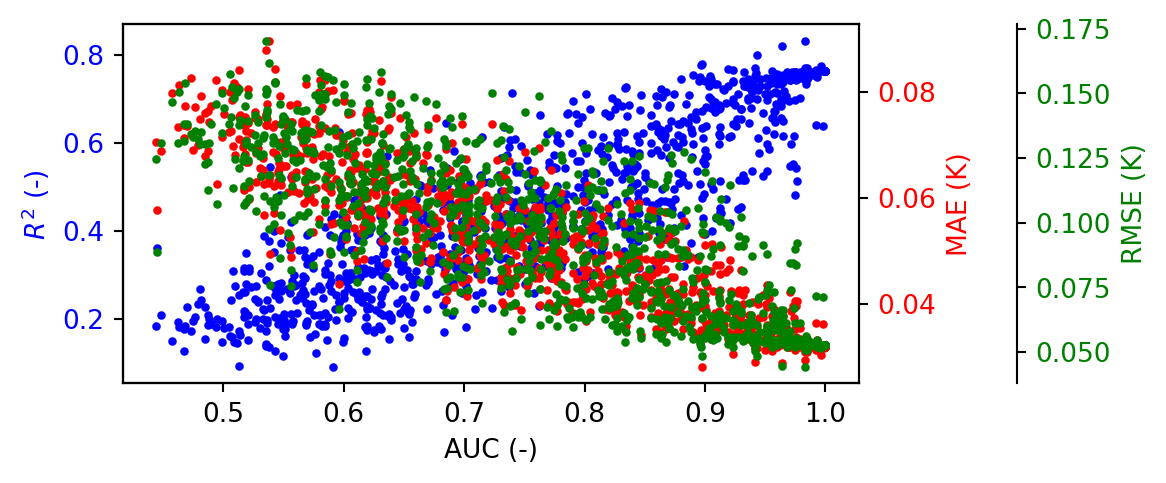

In [34]:
import matplotlib.pyplot as plt

# Create a figure and an initial axis
fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=190)

# First scatter plot for R^2
ax1.scatter(AUC, r2_vector, s=5, color='b', label='$R^2$')
ax1.set_xlabel('AUC (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.scatter(AUC, mae_vector, s=5, color='r', label='MAE (K)')
ax2.set_ylabel('MAE (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))  # Move it 60 points away from ax2
ax3.scatter(AUC, rmse_vector, s=5, color='g', label='RMSE (K)')
ax3.set_ylabel('RMSE (K)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add a legend to distinguish between the different data series
#fig.legend(loc="center", bbox_to_anchor=(0.68, 0.75), frameon = False)#, bbox_transform=ax1.transAxes)

plt.show()

## Validation 2

In [39]:
#MPj creation
MPj = pd.read_excel('mats_from_MPj.xlsx', index_col = 0) # MaterialsProject database
MPj = MPj.rename(columns={"pretty_formula": "Components"})
MPj = MPj.dropna()

normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(MPj))):
    MPj['Components'].iloc[i] = normalizer.normalized_formula(MPj['Components'].iloc[i])
    
MPj = MPj[['Components']].drop_duplicates()

100%|█████████████████████████████████████████████████████████████████████████| 154715/154715 [07:36<00:00, 338.58it/s]


In [40]:
MPj = featurizing(MPj)

MultipleFeaturizer:   0%|          | 0/105582 [00:00<?, ?it/s]

In [41]:
MPj['temperature(K)'] = 329
MPj = MPj[list(Output_shap_mean.index)[:32]]

In [42]:
Cluster_1 = reduced_Data[reduced_Data['Cluster'] == 1]
Cluster_0 = reduced_Data[reduced_Data['Cluster'] == 0]

In [43]:
Cluster_0_regr = Cluster_0.sample(frac = 0.5, random_state = 0)

In [44]:
train_df_2, test_df_2 = train_test_split(Cluster_0_regr, test_size = 0.2, random_state = 0)
etr_valid_2 = ExtraTreesRegressor(random_state = 0)
etr_valid_2.fit(train_df_2.iloc[:, :-2], train_df_2.iloc[:, -2])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

In [45]:
MPj = MPj.reset_index()
MPj['is_in_regr_0'] = 0
for i in tqdm.tqdm(range(len(MPj))):
    if MPj['Components'].iloc[i] in list(Cluster_0_regr.index):
        MPj['is_in_regr_0'].iloc[i] = 1
MPj = MPj.set_index('Components')

100%|███████████████████████████████████████████████████████████████████████| 105582/105582 [00:02<00:00, 35438.58it/s]


In [46]:
MPj_no_regr_0 = MPj[MPj['is_in_regr_0'] == 0].dropna()
Cluster_0_regr = Cluster_0_regr.iloc[:, :-2]
Cluster_0_regr['is_in_regr_0'] = 1

In [47]:
import random
idxs_random = random.sample(set(MPj_no_regr_0.index), 
                                   len(Cluster_0_regr))

MPj_no_regr_0_subset = MPj_no_regr_0.loc[idxs_random]
df_valid_2 = pd.concat([Cluster_0_regr, MPj_no_regr_0_subset])

In [48]:
model_2_validation = {}

for j in tqdm.tqdm(range(10)):

    seed_value = j
    random.seed(seed_value+1)
    idxs_random = random.sample(set(MPj_no_regr_0.index), 
                                       len(Cluster_0_regr))

    MPj_no_regr_0_subset = MPj_no_regr_0.loc[idxs_random]
    df_valid_2 = pd.concat([Cluster_0_regr, MPj_no_regr_0_subset])
    
    df_valid_2 = df_valid_2.dropna()
    train_df_valid_2, test_df_valid_2 = train_test_split(df_valid_2, test_size = 0.2, random_state = 0)
    
    model_valid_2 = ExtraTreesClassifier(random_state = 0)
    model_valid_2.fit(train_df_valid_2.iloc[:, :-1], train_df_valid_2.iloc[:, -1])
    
    test_predictions_valid_2 = model_valid_2.predict(test_df_valid_2.iloc[:, :-1]) 
    test_labels_valid_2 = test_df_valid_2.iloc[:, -1].values
    test_proba_predictions_valid_2 = model_valid_2.predict_proba(test_df_valid_2.iloc[:, :-1]) 
    fpr1, tpr1, thresholds1 = roc_curve(test_labels_valid_2, test_proba_predictions_valid_2.transpose()[1]) 

    print('F1 =', f1_score(test_labels_valid_2, test_predictions_valid_2), 
         'AUC =', roc_auc_score(test_df_valid_2['is_in_regr_0'], test_proba_predictions_valid_2.transpose()[1]))
    
    model_2_validation[f'model_valid_2_{j}'] = model_valid_2

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.75it/s]

F1 = 0.967032967032967 AUC = 0.9937198067632851
F1 = 0.9777777777777777 AUC = 0.9968599033816425


 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.73it/s]

F1 = 0.989010989010989 AUC = 0.9937198067632851
F1 = 0.967032967032967 AUC = 0.992512077294686


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.77it/s]

F1 = 0.9361702127659574 AUC = 0.9797101449275363
F1 = 0.9574468085106383 AUC = 0.9869565217391304


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  6.80it/s]

F1 = 0.9565217391304348 AUC = 0.9944444444444445
F1 = 0.9462365591397849 AUC = 0.9864734299516909


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.69it/s]

F1 = 0.9565217391304348 AUC = 0.9893719806763285
F1 = 0.9555555555555557 AUC = 0.9920289855072464


In [49]:
complete_test_df = pd.concat([Cluster_0.drop(Cluster_0_regr.index), Cluster_1])

In [50]:
for i in tqdm.tqdm(range(10)):

    probs_out = pd.DataFrame(model_2_validation[f'model_valid_2_{i}'].predict_proba(complete_test_df.iloc[:, :-2-i]), 
                 index = complete_test_df.index)

    complete_test_df[f'prob. classifier_{i}'] = probs_out[1]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.90it/s]


In [51]:
complete_test_df['avg_probability'] = np.mean(complete_test_df[['prob. classifier_0',
                 'prob. classifier_1',
                 'prob. classifier_2',
                 'prob. classifier_3',
                 'prob. classifier_4',
                 'prob. classifier_5',
                 'prob. classifier_6',
                 'prob. classifier_7',
                 'prob. classifier_8',
                 'prob. classifier_9']], axis = 1)

In [52]:
complete_test_df['ZT_predicted'] = etr_valid_2.predict(complete_test_df.iloc[:, :-13])
reduced = complete_test_df[['ZT', 'ZT_predicted', 'avg_probability']]

In [53]:
p_threshold = np.arange(0, 1, 1e-3)
r2_vector_valid_2 = np.zeros(len(p_threshold))
mae_vector_valid_2 = np.zeros(len(p_threshold))
rmse_vector_valid_2 = np.zeros(len(p_threshold))

for i in tqdm.tqdm(range(len(p_threshold))):
    df_modified = reduced.copy()
    df_modified = df_modified[df_modified['avg_probability'] > p_threshold[i]]
    
    
    r2_vector_valid_2[i] = sklearn.metrics.r2_score(df_modified['ZT'], df_modified['ZT_predicted'])
    mae_vector_valid_2[i] = mean_absolute_error(df_modified['ZT'], df_modified['ZT_predicted'])
    rmse_vector_valid_2[i] = np.sqrt(mean_squared_error(df_modified['ZT'], df_modified['ZT_predicted']))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 836.80it/s]


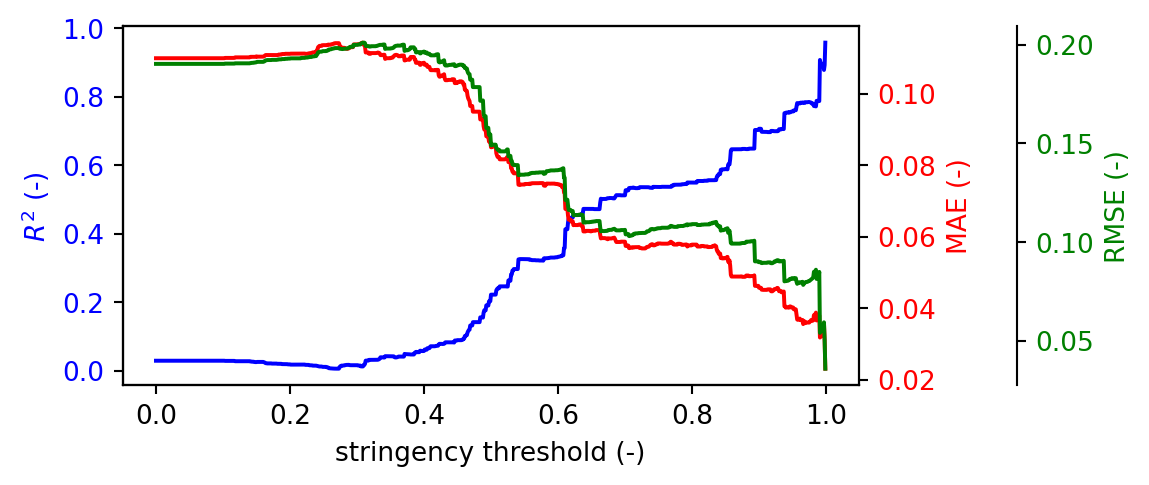

In [54]:
import matplotlib.pyplot as plt

# Create a figure and an initial axis
fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=190)

# First scatter plot for R^2
ax1.plot(p_threshold, r2_vector_valid_2, color='b', label='$R^2$')
ax1.set_xlabel('stringency threshold (-)')
ax1.set_ylabel('$R^2$ (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.plot(p_threshold, mae_vector_valid_2, color='r', label='MAE (-)')
ax2.set_ylabel('MAE (-)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Create a third y-axis for RMSE
ax3 = ax1.twinx()

# Offset the third y-axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))  
ax3.plot(p_threshold, rmse_vector_valid_2, color='g', label='RMSE (-)')
ax3.set_ylabel('RMSE (-)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.show()

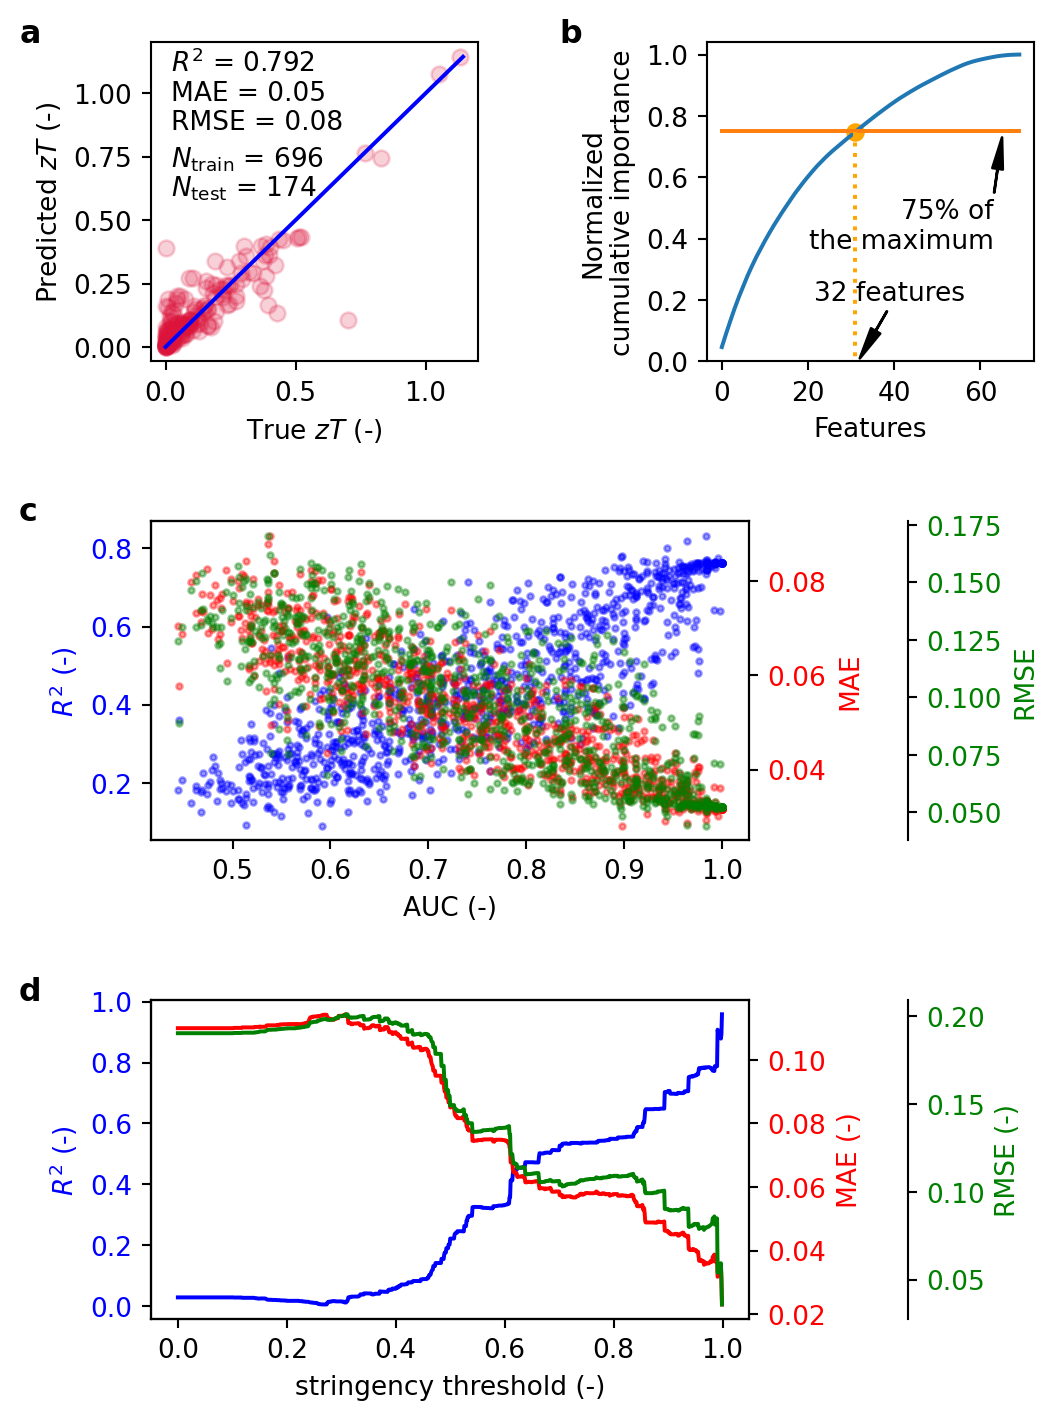

In [56]:
import matplotlib.pyplot as plt
import numpy as np


# Precompute values for the first plot
N = np.shape(X_test)[1]
k = 0.75
cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis=0))[::-1])
normalized_cumulative = cumsum / np.max(cumsum)
ind_cross1 = np.argmin(np.fabs(normalized_cumulative - k * np.ones(N)))

# Create a figure with constrained layout to include outward axes within the figure size
fig = plt.figure(figsize=(6, 8.9), dpi=190)  # Use constrained_layout=True
gs = fig.add_gridspec(3, 3)  # 3 rows, 2 columns

# --- First plot: scatter plot (ax1 in the original code) ---
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax1.scatter(test_labels, y_predictions, c='crimson', alpha=0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.annotate("$R^2$ = %0.3f" % r2, xy=(0.02 * (p1 - p2), 0.95 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.95 * (p1 - p2)))
ax1.annotate("MAE = %0.2f" % mae, xy=(0.02 * (p1 - p2), 0.85 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.85 * (p1 - p2)))
ax1.annotate("RMSE = %0.2f" % rmse, xy=(0.02 * (p1 - p2), 0.75 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.75 * (p1 - p2)))
ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), xy=(0.02 * (p1 - p2), 0.62 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.62 * (p1 - p2)))
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), xy=(0.02 * (p1 - p2), 0.52 * (p1 - p2)), xytext=(0.02 * (p1 - p2), 0.52 * (p1 - p2)))
ax1.set_xlabel("True $zT$ (-)")
ax1.set_ylabel("Predicted $zT$ (-)")
ax1.annotate('a', xy=(-.4, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Second plot: cumulative importance (ax2 in the original code) ---
ax2 = fig.add_subplot(gs[0, 2])  # Top-right
ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k * np.ones(N))
ax2.annotate('%i features' % (ind_cross1 + 1), ha='center', xy=(ind_cross1 + 1, .01), xytext=(ind_cross1 + 8, .2), arrowprops=dict(facecolor='black', shrink=0.000005, width=.1, headwidth=4))
ax2.annotate('75% of\nthe maximum', ha='right', xy=(65, 0.73), xytext=(63, 0.37), arrowprops=dict(facecolor='black', shrink=0.0005, width=.1, headwidth=4))
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color='orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color='orange', ls=':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')
ax2.annotate('b', xy=(-.45, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Third plot: scatter plots (ax3 in the new code) ---
gs = fig.add_gridspec(3, 2)  # 3 rows, 2 columns
gs.update(right=0.65)
ax3 = fig.add_subplot(gs[1, :])  # Second row, spanning both columns
ax3.scatter(AUC, r2_vector, s=5, color='b', label='$R^2$', alpha=0.4)
ax3.set_xlabel('AUC (-)')
ax3.set_ylabel('$R^2$ (-)', color='b')
ax3.tick_params(axis='y', labelcolor='b')

# Create second y-axis for MAE
ax3_twin2 = ax3.twinx()
ax3_twin2.scatter(AUC, mae_vector, s=5, color='r', label='MAE (K)', alpha=0.4)
ax3_twin2.set_ylabel('MAE', color='r')
ax3_twin2.tick_params(axis='y', labelcolor='r')

# Create third y-axis for RMSE
ax3_twin3 = ax3.twinx()
ax3_twin3.spines['right'].set_position(('outward', 60))
ax3_twin3.scatter(AUC, rmse_vector, s=5, color='g', label='RMSE (K)', alpha=0.4)
ax3_twin3.set_ylabel('RMSE', color='g')
ax3_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (c)
ax3.annotate('c', xy=(-.22, 1.001), xycoords='axes fraction', fontsize=12, fontweight='bold')

# --- Fourth plot: line plots (ax4 in the new code) ---
ax4 = fig.add_subplot(gs[2, :])  # Third row, spanning both columns
ax4.plot(p_threshold, r2_vector_valid_2, color='b', label='$R^2$')
ax4.set_xlabel('stringency threshold (-)')
ax4.set_ylabel('$R^2$ (-)', color='b')
ax4.tick_params(axis='y', labelcolor='b')

# Create second y-axis for MAE
ax4_twin2 = ax4.twinx()
ax4_twin2.plot(p_threshold, mae_vector_valid_2, color='r', label='MAE (K)')
ax4_twin2.set_ylabel('MAE (-)', color='r')
ax4_twin2.tick_params(axis='y', labelcolor='r')

# Create third y-axis for RMSE
ax4_twin3 = ax4.twinx()
ax4_twin3.spines['right'].set_position(('outward', 60))
ax4_twin3.plot(p_threshold, rmse_vector_valid_2, color='g', label='RMSE (K)')
ax4_twin3.set_ylabel('RMSE (-)', color='g')
ax4_twin3.tick_params(axis='y', labelcolor='g')

# Annotate subplot (d)
ax4.annotate('d', xy=(-.22, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

plt.subplots_adjust(hspace = 0.5, wspace = -0.15)

plt.show()
